## All imports

In [1]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
from data_loader import load_main_data, load_movie_titles
from data_transformer import flatten_data
from data_generator import generate_features, generate_biases, generate_user_embeddings, generate_movie_embeddings, generate_movie_embedings_with_genres
from data_splitting import data_split
from update_rules import update_user ,update_movie
from features_update import update_features, update_movie_with_features

import time


all_ratings = "ratings.csv"
all_genres = "movies.csv"

## Data loading and data processing

In [2]:
# Loading the main data
start = time.time()
data_user, data_movie, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx = load_main_data(all_ratings)
print("Finished loading main data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Splitting the data into training and testing sets
start = time.time()
data_by_user_train, data_by_user_test, data_by_movie_train = data_split(data_user, data_movie, ratio=0.8)
print("Finished splitting data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Loading movie titles and genres
start = time.time()
genres_of_a_single_movie, list_movies_per_genre, genres_to_idx = load_movie_titles(all_genres, movie_to_idx)  
print("Finished loading movie titles in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the genre data
start = time.time()
movie_genres_flat, index_movies = flatten_data(genres_of_a_single_movie)
print("Finished flattening genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the list of movies per genre
start = time.time()
list_movies_per_genre_flat, index_genres = flatten_data(list_movies_per_genre.values())
print("Finished flattening movies per genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Free up some memory
del genres_of_a_single_movie
del list_movies_per_genre
gc.collect()

Finished loading main data in 537.86 seconds.

Finished splitting data in 2.95 seconds.

Finished loading movie titles in 0.15 seconds.

Finished flattening genre data in 0.02 seconds.

Finished flattening movies per genre data in 0.01 seconds.



13375

### Data conversion

In [3]:
def convert_to_typed_list(data_list_of_lists):
    """
    Converts a List[List[Tuple(id, rating)]] into a 
    Numba Typed List[NumpyArray].
    """
    typed_list = List()
    for item in data_list_of_lists:
        # Convert tuples to a 2D numpy array of float64
        # Shape will be (N_ratings, 2) where col 0 is ID, col 1 is Rating
        if len(item) > 0:
            typed_list.append(np.array(item, dtype=np.float64))
        else:
            # Handle empty users/movies by adding an empty array
            typed_list.append(np.zeros((0, 2), dtype=np.float64))
    return typed_list

print("Converting data to Numba-friendly structures...")
start = time.time()
# Convert all 4 data structures
data_by_user_train_typed = convert_to_typed_list(data_by_user_train)
data_by_user_test_typed = convert_to_typed_list(data_by_user_test)
data_by_movie_train_typed = convert_to_typed_list(data_by_movie_train)
# We don't strictly need typed list for test if not passed to njit, 
# but consistency helps if you optimize evaluation later.

print("Finished conversion in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")

Converting data to Numba-friendly structures...
Finished conversion in 113.79 seconds.



In [4]:
# Free up some memory
del data_by_user_train
del data_by_user_test
del data_by_movie_train
gc.collect()

8355

## Hyperparameter setting and Training

In [5]:
N_iterations = 5*10**1
p_lambda = 2.0#2.0
p_gamma = 5.0#5.0
user_tau = movie_tau = 2.0#2.0
embedding_dim = 15

### Generating trait vectors

In [6]:
# Generating features, biases, embeddings
# We will start without the features first
num_users = len(idx_to_user)
num_movies = len(idx_to_movie)

# Biases
user_biases, movie_biases = generate_biases(num_users, num_movies)
print("Shapes of biases - Users: {}, Movies: {}".format(user_biases.shape, movie_biases.shape))

# User embeddings
user_embeddings = generate_user_embeddings(num_users, embedding_dim)
print("Shape of user embeddings: {}".format(user_embeddings.shape))

# Features
features_embedding = generate_features(20, embedding_dim, beta=0.05)
print("Shape of features embeddings : {}".format(features_embedding.shape))
features_embedding = np.array(features_embedding)
# Movie embeddings without genres
# movie_embeddings = generate_movie_embeddings(num_movies, embedding_dim)


movie_embeddings = generate_movie_embedings_with_genres(embedding_dim, movie_genres_flat, index_movies, features_embedding, movie_tau=user_tau)
print("Shape of movie embeddings with genres: {}".format(movie_embeddings.shape))

Shapes of biases - Users: (200948,), Movies: (84432,)
Shape of user embeddings: (200948, 15)
Shape of features embeddings : (20, 15)
Shape of movie embeddings with genres: (84432, 15)


In [7]:
features_embedding[:2]

array([[-0.30002868, -0.2302706 ,  0.29969457, -0.18322335,  0.04439902,
         0.11296636, -0.42238759,  0.0116853 , -0.0648493 , -0.15420762,
         0.06414301, -0.06775112, -0.07496137,  0.27186991, -0.12153791],
       [ 0.18261778,  0.09210225,  0.00503862, -0.02547455, -0.0858155 ,
         0.06596749,  0.3889656 ,  0.0492701 , -0.35627719, -0.10115204,
        -0.11798547, -0.11547732,  0.35949171, -0.02571422, -0.07807533]])

### Training

In [8]:
@njit(parallel=True, nogil=True)
def main_loop(
                data_by_user_train=data_by_user_train_typed,
                data_by_user_test=data_by_user_test_typed,
                data_by_movie_train=data_by_movie_train_typed,
                N_iterations=N_iterations,
                embedding_dim=embedding_dim,
                user_embeddings=user_embeddings,
                user_biases=user_biases,
                movie_embeddings=movie_embeddings,
                movie_biases=movie_biases,
                features_embedding_=features_embedding,
                list_movies_per_genre_flat=list_movies_per_genre_flat,
                index_movie=index_movies,
                movie_genres_flat=movie_genres_flat,
                index_genre=index_genres,
                p_lambda=p_lambda,
                p_gamma=p_gamma,
                user_tau=user_tau,
                movie_tau=movie_tau):
    """
    The main loop for training the model.

    And recording the results.
    """

    N = len(data_by_movie_train)
    M = len(data_by_user_train)

    # Trackers
    error_train = []
    error_test = []
    rmse_train_list = []
    rmse_test_list = []
    error_tracker = []
    
    print("Beginning main loop...")

    # Main loop for training the model would go here
    for iteration in range(N_iterations):

        # Then goes the user embeddings and the user biases update
        user_embeddings, user_biases = update_user(M,
                embedding_dim,
                data_by_user_train,
                movie_embeddings,
                user_embeddings,
                user_biases,
                movie_biases,
                p_lambda=p_lambda,
                user_tau=user_tau)

        movie_embeddings, movie_biases = update_movie_with_features(
            N,
            embedding_dim,
            data_by_movie_train,
            movie_embeddings,
            user_embeddings,
            user_biases,
            movie_biases,
            features_embedding_,
            movie_genres_flat,
            index_movie,
            p_lambda,
            p_gamma,
            movie_tau
        )
        
        # First goes the movie embeddings and the movie biases update
        # movie_embeddings, movie_biases = update_movie(N,
        #          embedding_dim,
        #          data_by_movie_train,
        #          movie_embeddings,
        #          user_embeddings,
        #          user_biases,
        #          movie_biases,
        #          p_lambda=p_lambda,
        #          p_gamma=p_gamma,
        #          user_tau=movie_tau)

        # Here goes the features update
        features_embedding_ = update_features(
                features_embedding_,
                movie_embeddings,
                movie_genres_flat,
                index_genre,
                list_movies_per_genre_flat,
                index_movie,
                embedding_dim,
)


        if (iteration + 1) % max(1, (N_iterations // 10)) == 0:
                print("Progressing...")

        if iteration <= 5 or (iteration + 1) % 5 == 0:
            err_test = 0.0
            err_train = 0.0
            total_ratings_train = 0
            total_ratings_test = 0

            for user_idx in range(M):
                current_train = data_by_user_train[user_idx]
                num_ratings_train = len(current_train)
                total_ratings_train += num_ratings_train
                if num_ratings_train == 0:
                    continue

                movies_idx = np.empty(num_ratings_train, dtype=np.int64)
                ratings = np.empty(num_ratings_train, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_train):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_train += np.sum((ratings - preds) ** 2)

            for user_idx in range(M):
                current_test = data_by_user_test[user_idx]
                num_ratings_test = len(current_test)
                total_ratings_test += num_ratings_test
                if num_ratings_test == 0:
                    continue

                movies_idx = np.empty(num_ratings_test, dtype=np.int64)
                ratings = np.empty(num_ratings_test, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_test):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_test += np.sum((ratings - preds) ** 2)

            rmse_train_val = 0.0
            rmse_test_val = 0.0
            if total_ratings_train > 0:
                rmse_train_val = np.sqrt(err_train / total_ratings_train)
            if total_ratings_test > 0:
                rmse_test_val = np.sqrt(err_test / total_ratings_test)

            reg_bias = (p_gamma / 2.0) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
            reg_embed = (user_tau / 2.0) * (np.sum(user_embeddings ** 2) + np.sum(movie_embeddings ** 2))

            err_test_reg = (err_test * (p_lambda / 2.0)) + reg_bias + reg_embed
            err_train_reg = (err_train * (p_lambda / 2.0)) + reg_bias + reg_embed

            error_tracker.append(iteration)
            rmse_train_list.append(rmse_train_val)
            rmse_test_list.append(rmse_test_val)
            error_test.append(err_test_reg)
            error_train.append(err_train_reg)

    return error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, user_biases, movie_biases, user_embeddings, movie_embeddings, features_embedding_

In [9]:
start = time.time()
user_embeddings_ = user_embeddings.copy()
movie_embeddings_ = movie_embeddings.copy()
features_embedding_ = features_embedding.copy()
user_biases_ = user_biases.copy()
movie_biases_ = movie_biases.copy()

main_loop_results = main_loop(
    data_by_user_train=data_by_user_train_typed,   
    data_by_user_test=data_by_user_test_typed,     
    data_by_movie_train=data_by_movie_train_typed, 
    N_iterations=N_iterations,
    embedding_dim=embedding_dim,
    user_embeddings=user_embeddings_,
    features_embedding_=features_embedding_,
    user_biases=user_biases_,
    movie_embeddings=movie_embeddings_,
    movie_biases=movie_biases_
)
print("Finished training in {:.2f} seconds.".format(time.time() - start))

(error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, ub, mb, ue, me, ft) = main_loop_results
print("=" * 25, "\n")
# print(error_tracker,'\n', error_test,'\n', error_train,'\n', rmse_test_list,'\n', rmse_train_list)



/tmp/ipykernel_14537/4214798676.py:43: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  user_embeddings, user_biases = update_user(M,


Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 314.94 seconds.



In [10]:
ft[:2]

array([[-0.19099848,  0.03013818,  0.213585  , -0.00816154, -0.0357371 ,
         0.1900761 , -0.23427429, -0.08798324,  0.13200512, -0.26911036,
         0.08113423,  0.09900953, -0.08811436,  0.04229068, -0.093904  ],
       [-0.13001769, -0.24082102, -0.12787397,  0.23012464,  0.79151309,
         0.67120628, -0.17731221, -0.11671087, -0.04246937, -0.31961318,
         0.16803129,  0.59647742, -0.67517766,  0.1670318 , -0.16841343]])

### Plotting the result

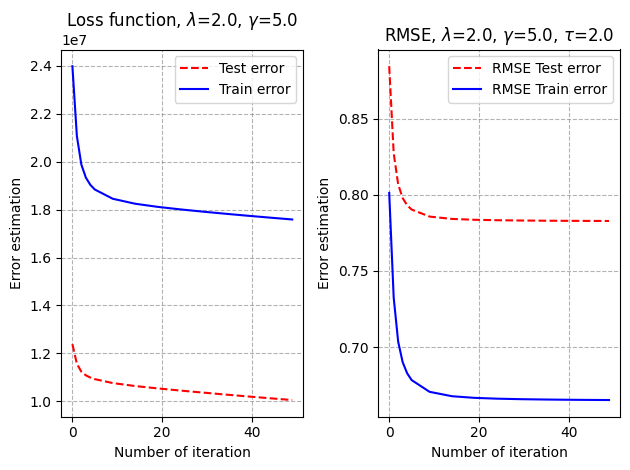

In [11]:
fig, ax = plt.subplots(1,2)
ax[0].plot(error_tracker, error_test, color="red", linestyle="dashed", label="Test error")
ax[0].plot(error_tracker, error_train, color="blue", linestyle="solid", label="Train error")
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Error estimation")
ax[0].set_title(f"Loss function, $\lambda$={p_lambda}, $\gamma$={p_gamma}")
ax[0].legend(loc="upper right")
ax[0].grid(True, linestyle='--', color='gray', alpha=0.6)


ax[1].plot(error_tracker, rmse_test_list, color="red", linestyle="dashed", label="RMSE Test error")
ax[1].plot(error_tracker, rmse_train_list, color="blue", linestyle="solid", label="RMSE Train error")
ax[1].set_xlabel("Number of iteration")
ax[1].set_ylabel("Error estimation")
ax[1].set_title(f"RMSE, $\lambda$={p_lambda}, $\gamma$={p_gamma}, $\\tau$={user_tau}")
ax[1].legend(loc="upper right")
ax[1].grid(True, linestyle='--', color='gray', alpha=0.6)

plt.tight_layout()
# plt.savefig(f"Error_{embedding_dim}_local_{p_lambda}_{p_gamma}_{user_tau}_func_no_feat.pdf")
# plt.savefig(f"Iterations_{N_iterations}_{p_lambda}_{p_gamma}_{user_tau}_{embedding_dim}.pdf")
plt.show()

In [12]:
rmse_test_list[:]

[0.8843936150835866,
 0.8272193395945405,
 0.8067984718838513,
 0.7978063412672899,
 0.7931126074705852,
 0.7903028796454397,
 0.7856805084273307,
 0.7841319283018267,
 0.7835759314116496,
 0.7832851955656729,
 0.7831041791374548,
 0.7829805927084055,
 0.7828944444357376,
 0.782835384893818,
 0.7827950938684156]

#### Hyperparameter selection
After fixing the number of iteration, we will choose the three remaining hyperparamters as follows :
- $\lambda \in \{0.5, 1.0, 2.0\}$
- $\gamma \in \{1.0, 2.0, 5.0\}$
- $\tau \in \{0.5, 1.0, 2.0\}$

After the run is over, we use `plotting.py` to assess the results of all the runs and pick the parameters that are always strictly decreasing.

Only uncomment when needed since it takes at least 1 hour and 30 minutes 😀 

In [ ]:
# from itertools import product
# lambda_choice = [0.5, 1.0, 2.0]
# gamma_choice = [1.0, 2.0, 5.0]
# tau_choice = [0.5, 1.0, 2.0]

# for lambda_, gamma_, tau_ in product(lambda_choice, gamma_choice, tau_choice):
#     user_embeddings_ = user_embeddings.copy()
#     movie_embeddings_ = movie_embeddings.copy()
#     features_embedding_ = features_embedding.copy()
#     user_biases_ = user_biases.copy()
#     movie_biases_ = movie_biases.copy()
#     start = time.time()
#     main_loop_results = main_loop(
#         data_by_user_train=data_by_user_train_typed,   
#         data_by_user_test=data_by_user_test_typed,     
#         data_by_movie_train=data_by_movie_train_typed, 
#         N_iterations=50,
#         embedding_dim=embedding_dim,
#         user_embeddings=user_embeddings_,
#         features_embedding_=features_embedding_,
#         user_biases=user_biases_,
#         movie_embeddings=movie_embeddings_,
#         movie_biases=movie_biases_,
#         p_lambda=lambda_,
#         p_gamma=gamma_,
#         user_tau=tau_,
#         movie_tau=tau_
#     )
#     print("Finished training in {:.2f} seconds.".format(time.time() - start))

#     (error_tracker, _, _, rmse_test_list, _, _, _, _, _, _) = main_loop_results
#     with open(f"result_test_{lambda_}_{gamma_}_{tau_}.txt", 'w') as fp:
#         for iteration, val in zip(error_tracker, rmse_test_list):
#             fp.write(f"{iteration}\t{val}\n")
    
#     print("=" * 25, "\n")

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 209.47 seconds.

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 196.39 seconds.

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 198.54 seconds.

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 201.22 seconds.

Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing..

In [15]:
# np.save("movie_embeddings.npy", me)
# np.save("user_embeddings.npy", ue)
# np.save("features_embedding.npy", ft)

## Making prediction

In [13]:
import pandas as pd

movie_name_df = pd.read_csv(all_genres)

### Initializing the user

In [14]:
new_user = 1 / np.sqrt(embedding_dim) * np.random.randn(embedding_dim)

#Insert the movie index that the new user has rated
noted_movie_idx = movie_to_idx[7153]
rating = 5.0
tau = user_tau

### Prediction loop and Polarizing movies

In [15]:
def new_user_recommend(new_user, noted_movie_idx, rating,idx_to_movie=idx_to_movie, movie_name_df=movie_name_df, embed_movie=me, movie_biases=mb, p_lambda=p_lambda, p_gamma=p_gamma, tau=user_tau):
    loop = 20
    bias = 0.0
    movie = embed_movie[noted_movie_idx]
    outer = np.outer(movie, movie)
    invert_this = p_lambda * outer + tau * np.identity(movie.shape[0])
    movie_bias = movie_biases[noted_movie_idx]

    for i in range(loop):
        # Update the user's bias first
        bias = p_lambda * (rating - new_user @ movie - movie_bias)
        bias = bias / (p_lambda + p_gamma)

        # Update the trait vector afterward
        new_user = np.linalg.solve(invert_this, p_lambda * (rating - bias - movie_bias) * movie)

    print("Finished creating user profile")
    print("The movie that the user liked : ", 
      movie_name_df.loc[movie_name_df["movieId"] == idx_to_movie[noted_movie_idx], "title"])
    print("==" * 25,"*" * 5, "==" * 25)
    res = embed_movie @ new_user + bias + 0.05 * movie_biases
    print(res.argsort())
    concat = np.hstack([np.array(range(res.shape[0])).reshape(-1,1).astype(np.int32), res.reshape(-1,1)])
    sorted_res = concat[concat[:, 1].argsort()[::-1]]
    ten_best = sorted_res[:10]
    

    res =  {
        int(index) : float(rating) for index, rating in ten_best
    }

    mv_idx = list(res.keys())
    real_indexes = []
    for mv in mv_idx:
        real_indexes.append(idx_to_movie[mv])

    names = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "title"]
    genres = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "genres"]

    print()
    print("=" * 100)
    print(f"{'Movie name':<40} || {'Movie genre'}")    
    print("=" * 100)
    for name, genre in zip(names, genres):
        print(f"{name:<40} || {genre}")
    
    # Searching for the polarizing movies
    top_ten_index = ten_best[:, 0].astype(np.int32)
    print("\nThe most polarizing movies in selection are (3 longest trait vectors):\n")
    norms = np.sum(np.square(me[top_ten_index]), axis=1)
    long_norms = np.argsort(norms)[-3:][::-1]

    print(norms[long_norms])
    print(names.iloc[long_norms])

In [16]:
new_user_recommend(new_user, noted_movie_idx, rating)

Finished creating user profile
The movie that the user liked :  7029    Lord of the Rings: The Return of the King, The...
Name: title, dtype: object
================================================== ***** ==================================================
[23654  4813  9534 ...   596   339   613]

Movie name                               || Movie genre
Braveheart (1995)                        || Action|Drama|War
Star Wars: Episode IV - A New Hope (1977) || Action|Adventure|Sci-Fi
Star Wars: Episode V - The Empire Strikes Back (1980) || Action|Adventure|Sci-Fi
Star Wars: Episode VI - Return of the Jedi (1983) || Action|Adventure|Sci-Fi
Lord of the Rings: The Fellowship of the Ring, The (2001) || Adventure|Fantasy
Lord of the Rings: The Two Towers, The (2002) || Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) || Action|Adventure|Drama|Fantasy
Hobbit: An Unexpected Journey, The (2012) || Adventure|Fantasy|IMAX
Hobbit: The Desolation of Smaug, The (2013) || Adventu

In [148]:
movie_name_df[movie_name_df["title"].str.contains("Rings")]

,movieId,title,genres
2026,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
3432,3529,"Postman Always Rings Twice, The (1981)",Crime|Thriller
4888,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5841,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7029,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
7425,7728,"Postman Always Rings Twice, The (1946)",Crime|Drama|Film-Noir|Thriller
17438,91362,Rings on Her Fingers (1942),Comedy|Romance
27782,129913,Rings (2005),Horror|Thriller
33702,143194,Rings of Fear (1978),Horror
44861,168060,Rings (2017),Horror


### 2D plots of the trait vectors

#### Features selection (only the two first components)

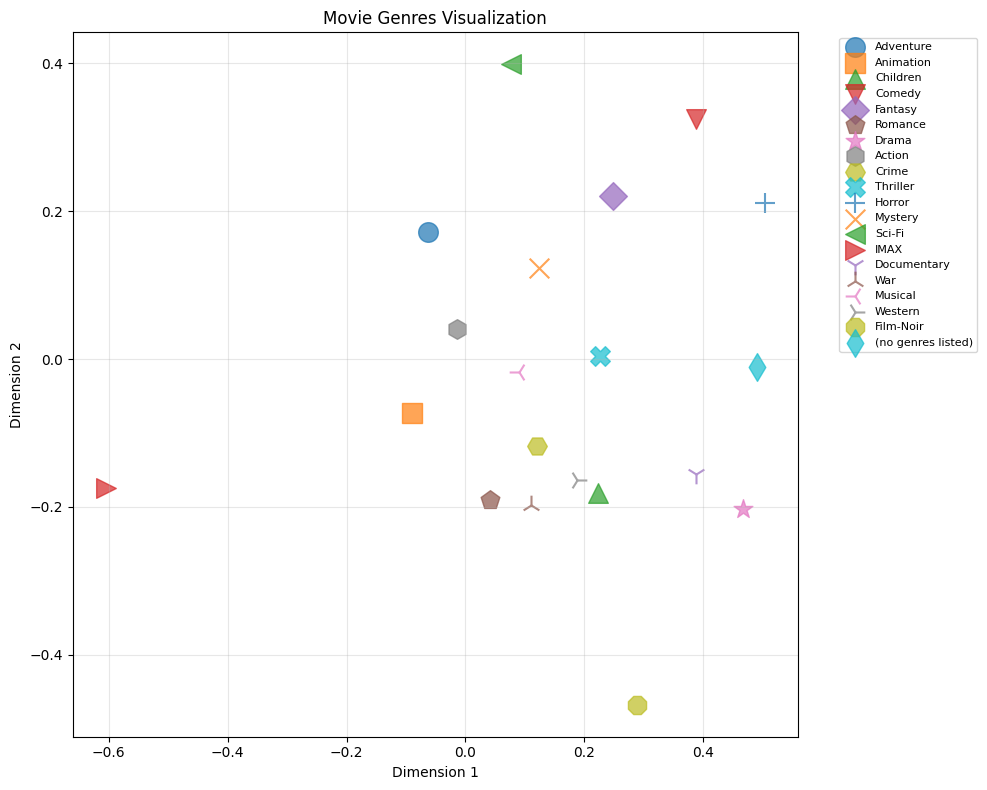

In [193]:
genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(ft[i, 0], ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("movie_genres_visualization_20.pdf")
plt.show()

In [18]:
movie_embedding_mean = np.mean(me, axis=0) 
movie_embedding_std = np.std(me, axis=0)

feature_mean = np.mean(ft, axis=0) 
feature_std = np.std(ft, axis=0) 

std_me = (me - movie_embedding_mean) / movie_embedding_std
std_ft = (ft - feature_mean) / feature_std

#### Principal Component Analysis

[0.16698568 0.10896937]
[459.87391524 371.49364811]


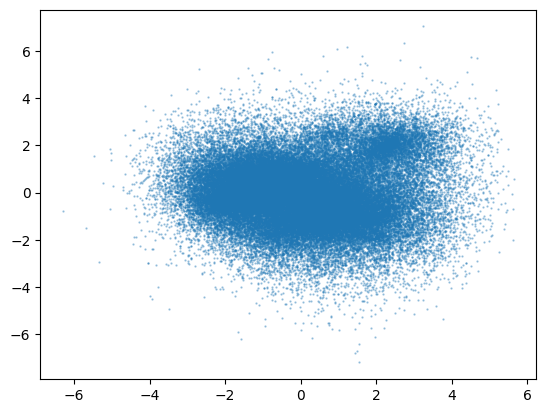

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_repr = pca.fit_transform(std_me)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(pca_repr[:, 0], pca_repr[:, 1], s=0.4, alpha=0.4)
plt.show()

[0.25745594 0.19369546]
[8.78844602 7.62290214]


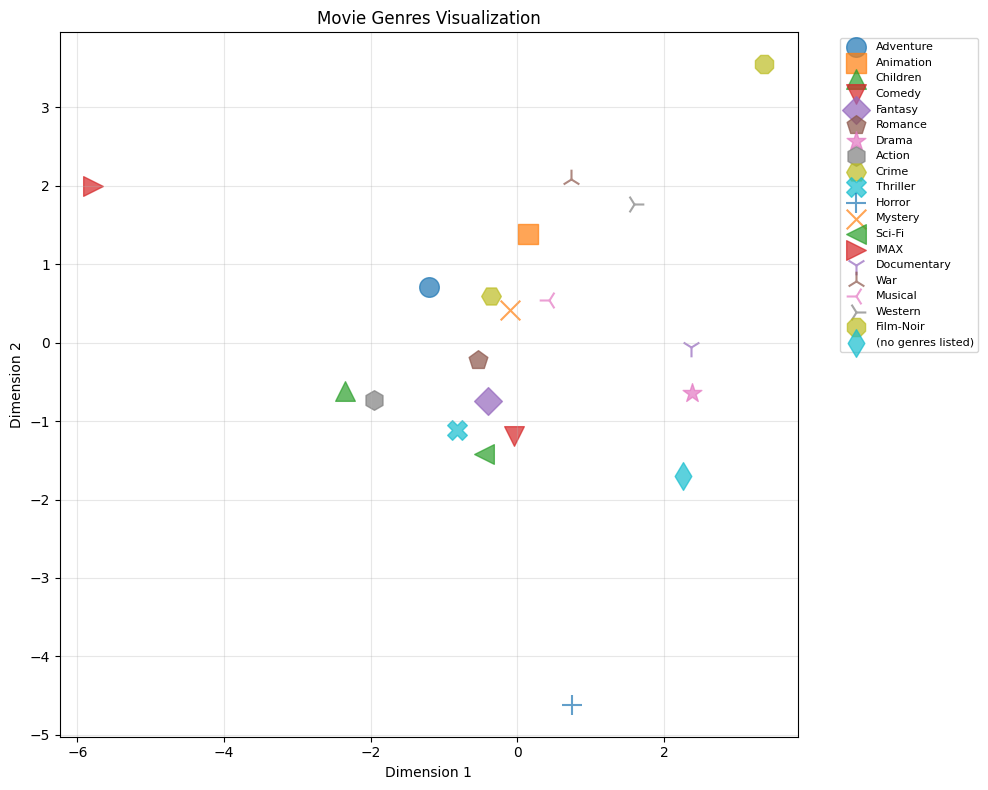

In [38]:
pca_ = PCA(n_components=2)
pca_repr_ft = pca_.fit_transform(std_ft)
print(pca_.explained_variance_ratio_)
print(pca_.singular_values_)


genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(pca_repr_ft[i, 0], pca_repr_ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("movie_genres_visualization.pdf")
plt.show()

#### t-SNE 2D plots

In [197]:
from sklearn.manifold import TSNE
tsne_repr = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(std_me)
tsne_repr.shape

(84432, 2)

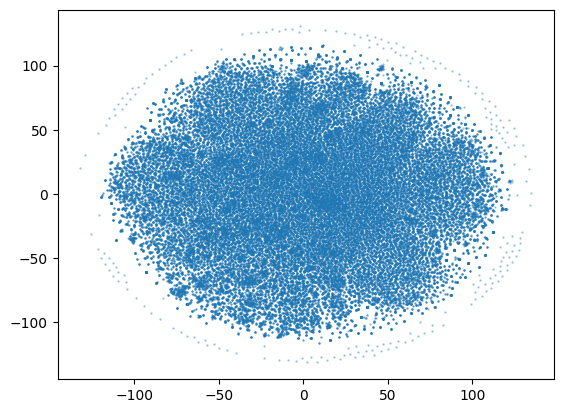

In [198]:
plt.scatter(tsne_repr[:, 0], tsne_repr[:, 1], s=0.4, alpha=0.4)
plt.show()

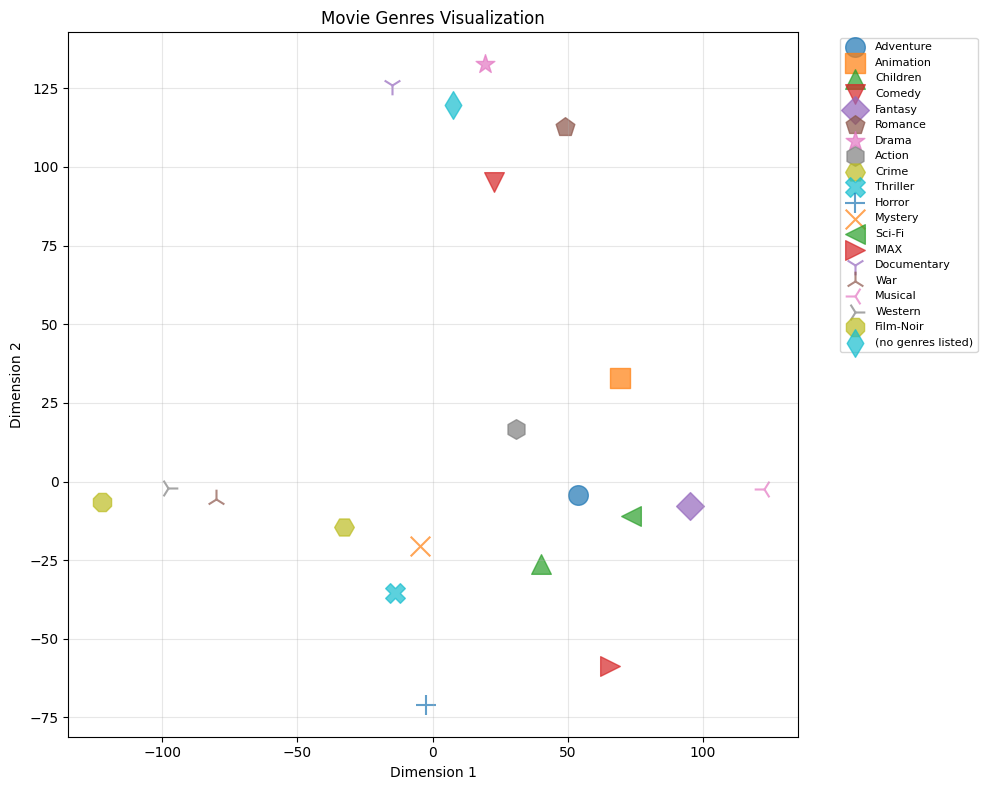

In [199]:
tsne_repr_ft = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(std_ft)
tsne_repr_ft.shape

genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(tsne_repr_ft[i, 0], tsne_repr_ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("movie_genres_visualization.pdf")
plt.show()

In [39]:
print(genres)

samples = []
n_sampling = 10

for genre in genres:
    genre_sample = (
        movie_name_df[
            movie_name_df['genres'].str.contains(genre, case=False, na=False, regex=False)
        ]
        .sample(n=n_sampling)
    )
    samples.append(genre_sample)

samples_df = pd.concat(samples, ignore_index=True)


['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


In [40]:
samples_df.head()

,movieId,title,genres
0,173291,Valerian and the City of a Thousand Planets (2...,Action|Adventure|Sci-Fi
1,152769,Road to Your Heart (2014),Adventure|Romance
2,129675,Wolf Totem (2015),Adventure
3,264063,Conrad: The Factory-Made Boy (1983),Adventure|Children|Comedy
4,7070,Red River (1948),Action|Adventure|Western


In [41]:
ids = samples_df["movieId"].to_numpy()
ids.shape

(200,)

In [ ]:
from collections import defaultdict

genre_samples = defaultdict(list)

genre_count = 0
for j, id in enumerate(ids):
    try:
        idx = int(movie_to_idx[id])
        genre_samples[genres[genre_count]].append(idx)
    except KeyError:
        continue

    if (j + 1) % n_sampling == 0:
        genre_count += 1


189


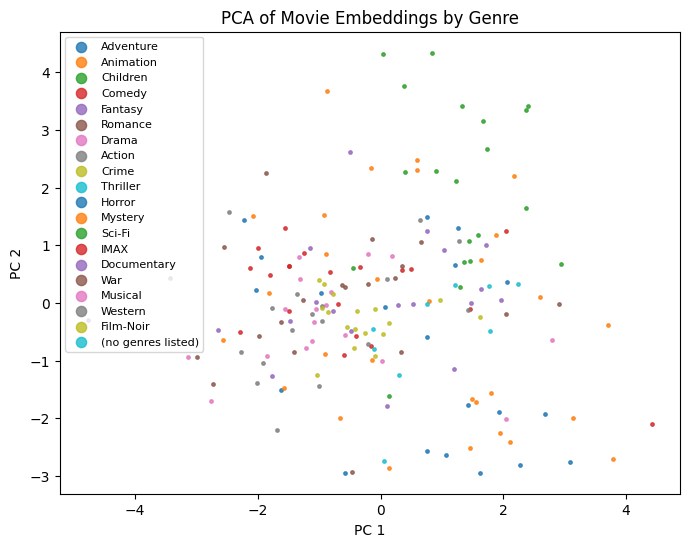

In [ ]:
all_idx = []
for ids in genre_samples.values():
    all_idx.extend(ids)

print(len(all_idx))
X_samples = me[all_idx]

# Standardize
X_mean = X_samples.mean(axis=0)
X_std = X_samples.std(axis=0)

standardized = (X_samples - X_mean) / X_std
pca_repr_samples = PCA(n_components=2)
pca_repr = pca_repr_samples.fit_transform(standardized)


plt.figure(figsize=(8, 6))
count = 0
for genre in genres_to_idx.keys():
    elt_in_genre = len(genre_samples[genre])
    plt.scatter(
        pca_repr[count: count + elt_in_genre, 0],
        pca_repr[count: count + elt_in_genre, 1],
        s=6,
        alpha=0.8,
        label=genre
    )
    count += elt_in_genre
    
plt.legend(markerscale=3, fontsize=8)
plt.title("PCA of Movie Embeddings by Genre")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig("dim_15_100.pdf")
plt.show()


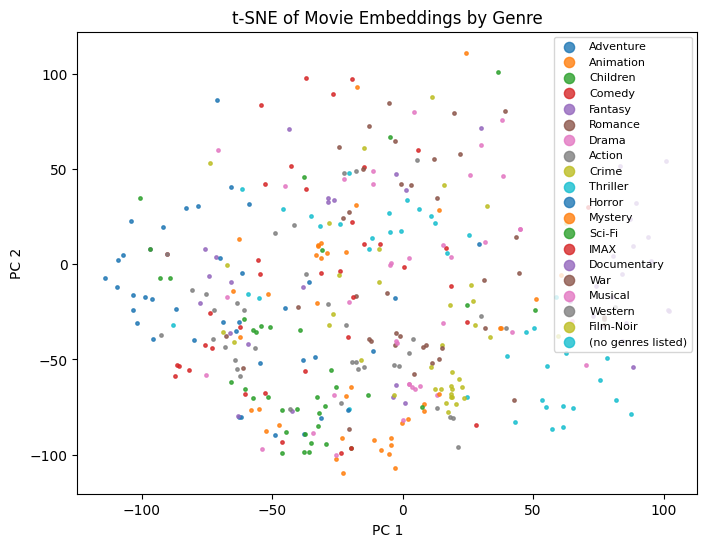

In [ ]:
plt.figure(figsize=(8, 6))

for genre, idxs in genre_samples.items():
    plt.scatter(
        tsne_repr[idxs, 0],
        tsne_repr[idxs, 1],
        s=6,
        alpha=0.8,
        label=genre
    )

plt.legend(markerscale=3, fontsize=8)
plt.title("t-SNE of Movie Embeddings by Genre")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.savefig("Labels.pdf")
plt.show()